In [92]:
import numpy as np
from functools import partial, reduce
import pylab as plt
# %matplotlib inline
from PIL import Image
from math import pi
from colorsys import hls_to_rgb
from scipy import fftpack
from skimage import draw
from matplotlib import gridspec
from scipy.misc import imread

In [148]:
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + pi)  / (2 * pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c


def prep_array(PTA=None, offset_x=0, offset_y=0):
    if PTA == None:
        PTA = np.ndarray((512, 512), dtype=float)
    PTA[256+offset_y][256+offset_x] = 1.0
    return PTA

def generic_fft(arr, inverse=False):
    FPTA = fftpack.fftshift(arr)
    if inverse:
        FPTA = fftpack.ifft2(FPTA)
    else:
        FPTA = fftpack.fft2(FPTA)
    FPTA = fftpack.fftshift(FPTA)
    return FPTA

def vis_diffractogram(FPTA):
    # Replicates the diffract function from the notes
    # Now, colorize the Re + Im plot
    img = colorize(FPTA)
#     print("0th, 0th: {}".format(FPTA[0][0]))
    plt.title('Complex - Re + Im part')
    plt.imshow(img, interpolation='none')
    plt.show()
    plt.title('Real part')
    plt.imshow(np.real(FPTA))
    plt.show()
    plt.title('Imaginary part')
    plt.imshow(np.imag(FPTA))
    plt.show()
    plt.title('Amplitude')
    plt.imshow(np.absolute(FPTA), interpolation='none')
    plt.show()
    amplitude_slice_x = np.absolute(FPTA)[256]
    amplitude_slice_y = np.absolute(FPTA)[:,256]
    plt.title("Amplitude X direction plot")
    plt.plot(amplitude_slice_x)
    plt.show()
    plt.title('Amplitude X direction log plot')
    plt.plot(amplitude_slice_x)
    plt.yscale('log')
    plt.show()
    plt.title("Amplitude Y direction log plot")
    plt.plot(amplitude_slice_y)
    plt.yscale('log')
    plt.show()
    return (amplitude_slice_x, amplitude_slice_y)
#     fig.save()

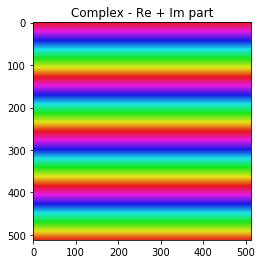

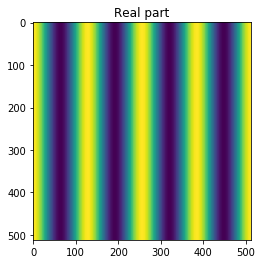

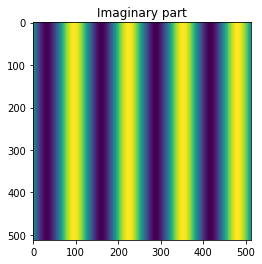

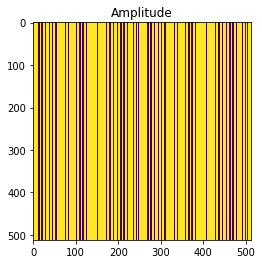

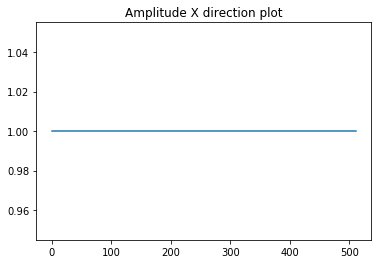

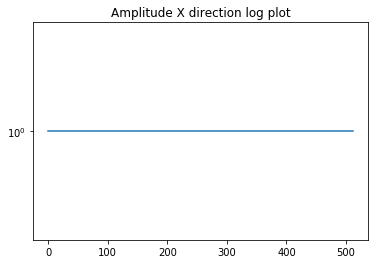

/home/nicholas/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


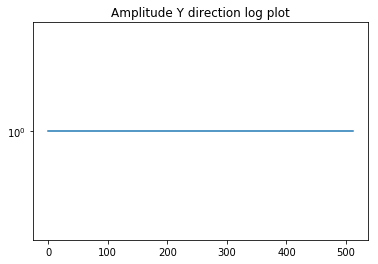

In [149]:
AMP_FTPA = vis_diffractogram(generic_fft(prep_array(None,4)))

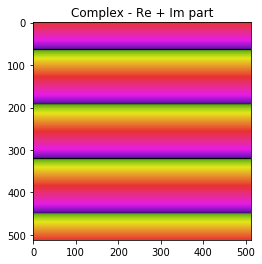

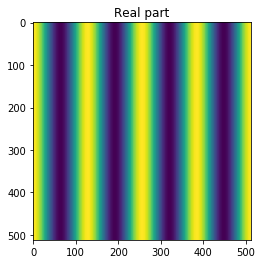

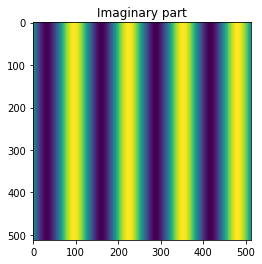

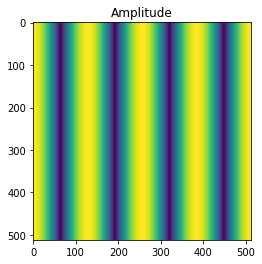

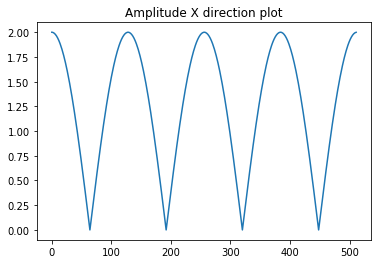

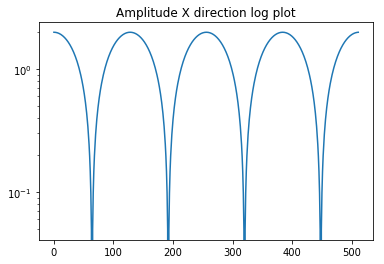

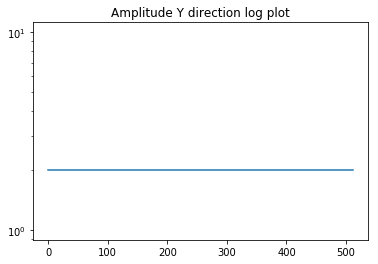

In [158]:
#FPTAB4 - point source offset by four, in the x direction
individual_point_sources = [prep_array(), prep_array(None, 4, 0)]
double_point_source = reduce(lambda u,v: u+v, individual_point_sources)
FPTAB4 = generic_fft(double_point_source)
double_point_FTPA = vis_diffractogram(FPTAB4)

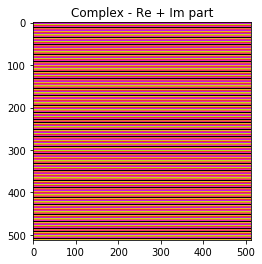

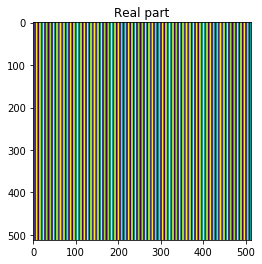

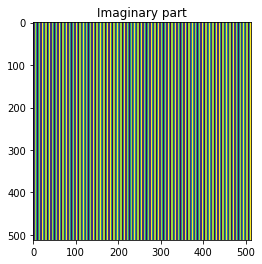

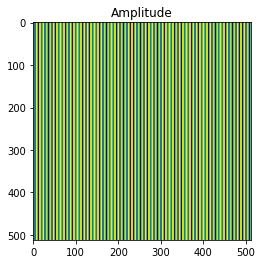

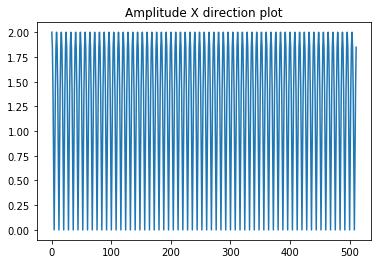

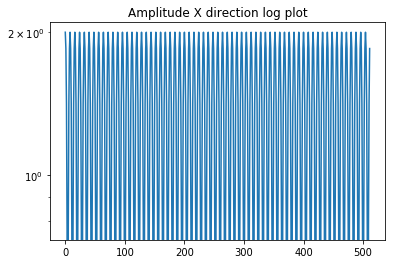

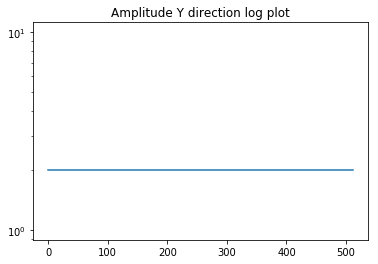

In [159]:
#FPTAB64 - point source offset by 64, in the x direction
individual_point_sources = [prep_array(), prep_array(None, 64, 0)]
double_point_source = reduce(lambda u,v: u+v, individual_point_sources)
FPTAB64 = generic_fft(double_point_source)
amp_FPTAB64 = vis_diffractogram(FPTAB64)

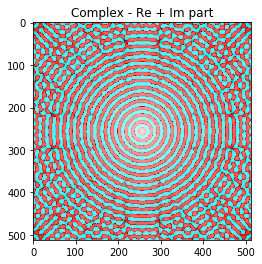

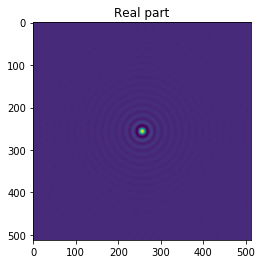

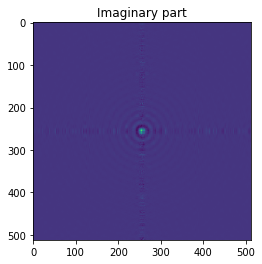

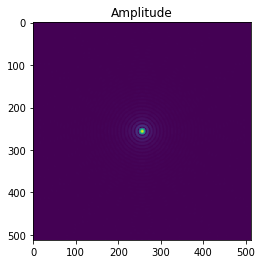

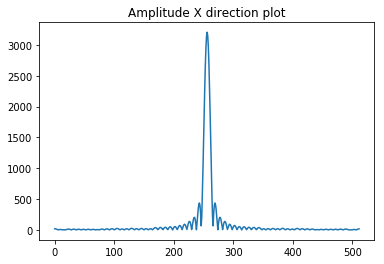

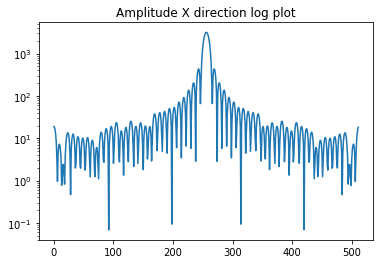

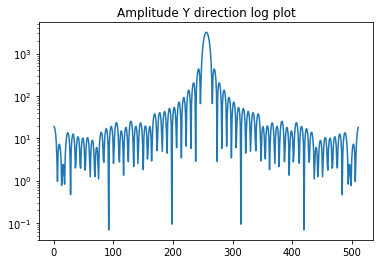

In [169]:
# Circular aperture time
CIRCA = np.zeros((512, 512))
rr, cc = draw.circle(256, 256, radius=32, shape=CIRCA.shape)
CIRCA[rr, cc] = 1

FCIRCA_amp = vis_diffractogram(generic_fft(CIRCA))

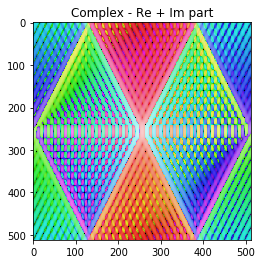

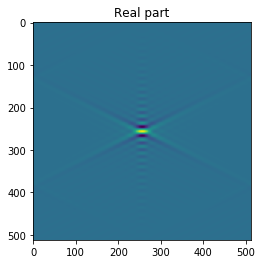

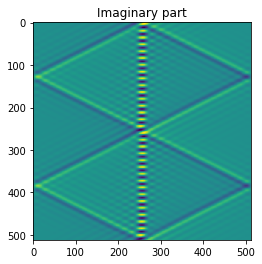

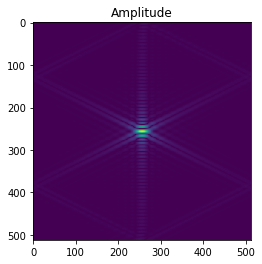

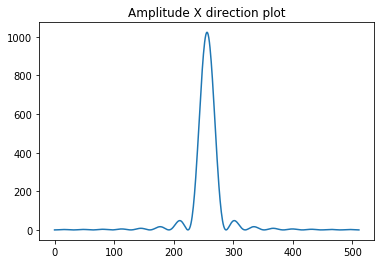

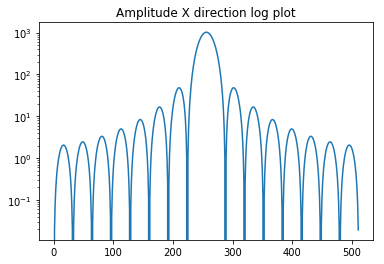

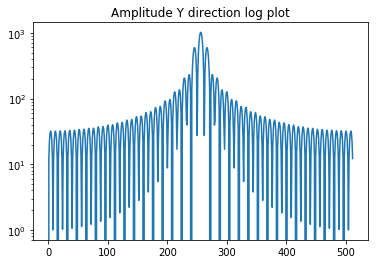

In [166]:
# rectangular aperture
RECTA = np.zeros((512, 512))
rect_width = 32
rect_height = 64
# generate the rectangle, as per the required dimensions
def gen_rect(width, height):
    return np.array((
    (256-width/2, 256-height/2),
    (256-width/2, 256+height/2),
    (256+width/2, 256-height/2),
    (256+width/2, 256+height/2),
))
rect = gen_rect(64, 32)
rr, cc = draw.polygon(rect[:, 0], rect[:, 1], RECTA.shape)
RECTA[rr, cc] = 1.0
FRECTA = generic_fft(RECTA)
amp_x, amp_y = vis_diffractogram(FRECTA)

In [153]:
amp_l_x = list(amp_x)
indices_x = [i for i, x in enumerate(amp_l_x) if x == min(amp_l_x)]
amp_l_y = list(amp_y)
indices_y = [i for i, x in enumerate(amp_l_y) if x == min(amp_l_y)]


In [154]:
print(indices_x)
print(indices_y)

[0, 32, 64, 96, 128, 160, 192, 224, 288, 320, 352, 384, 416, 448, 480]
[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496]


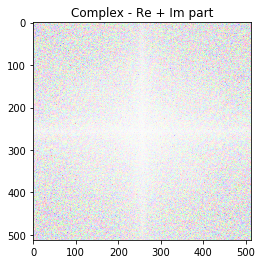

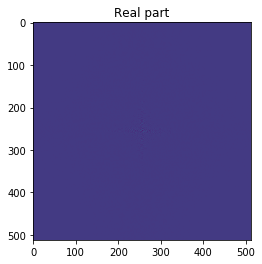

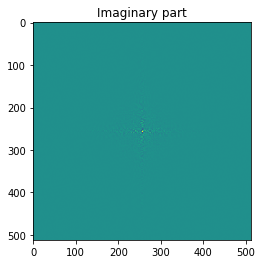

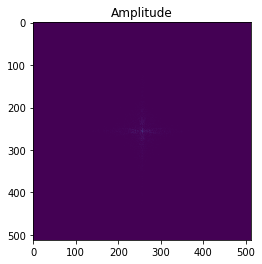

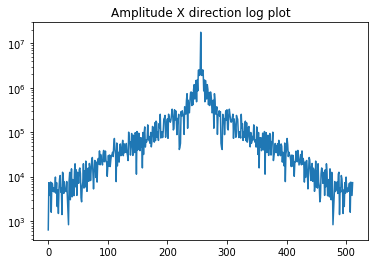

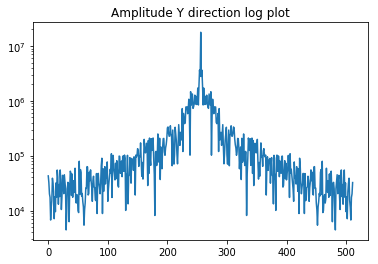

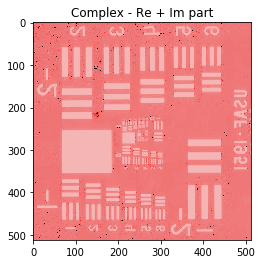

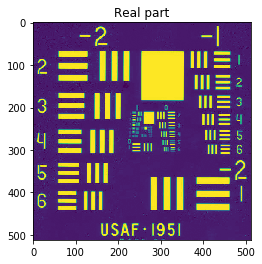

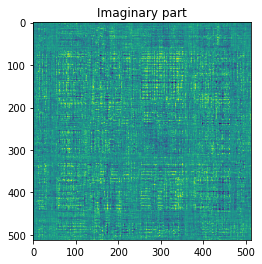

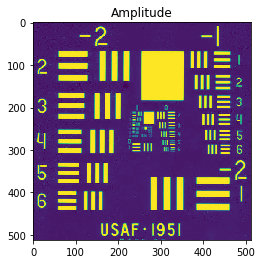

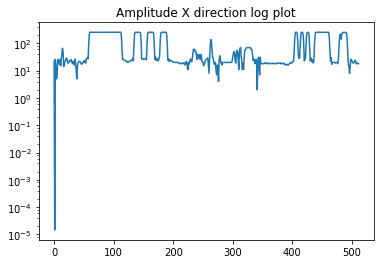

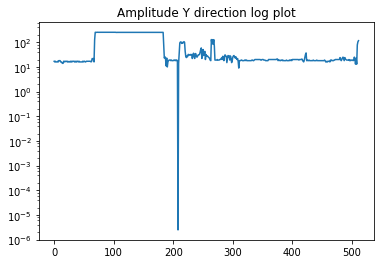

In [139]:
arr = imread('../USAF512.bmp', flatten=True)
# FUSAF_amp = generic_diffractogram(arr)
FUSAF = generic_fft(arr)
amp_FUSAF_pair = vis_diffractogram(FUSAF)
IFUSAF = generic_fft(FUSAF, inverse=True)
amp_IFUSAF_pair = vis_diffractogram(IFUSAF)

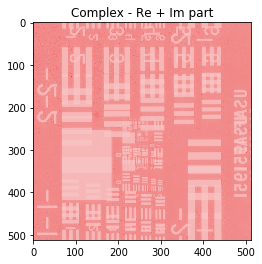

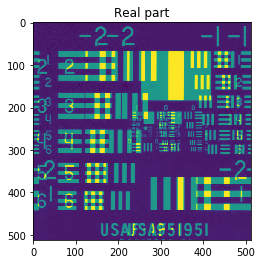

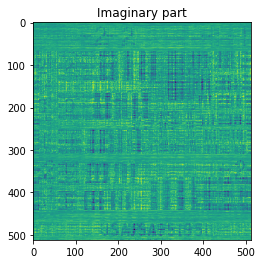

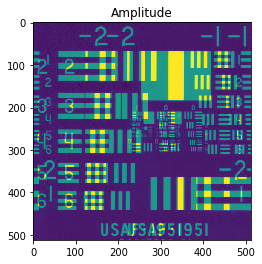

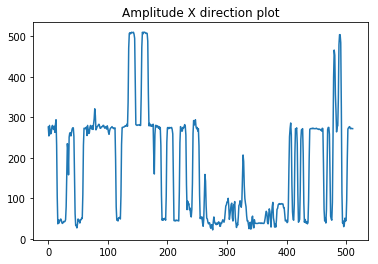

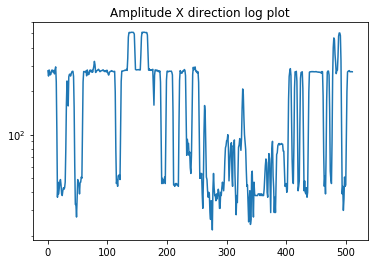

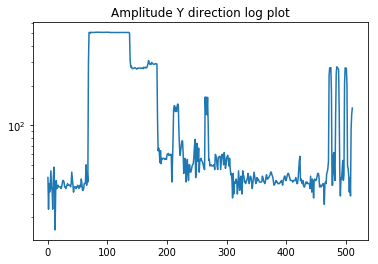

In [162]:
# Part 10, image convolution of FPTAB64, FUSAF
convolved_FUSAF_FPTAB64 = generic_fft(np.multiply(FUSAF, FPTAB64), inverse=True)
amp_ic_FUSAF_FPTAB64 = vis_diffractogram(convolved_FUSAF_FPTAB64)

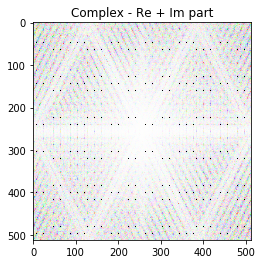

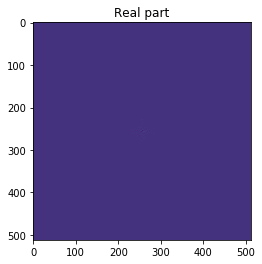

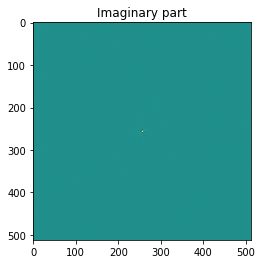

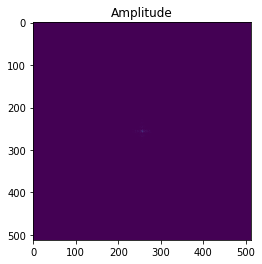

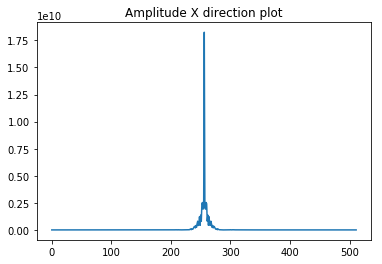

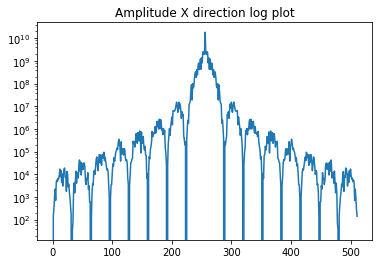

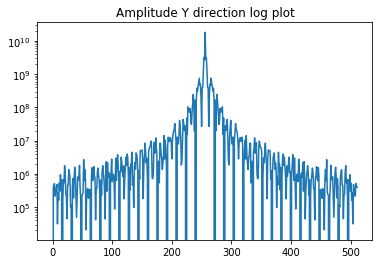

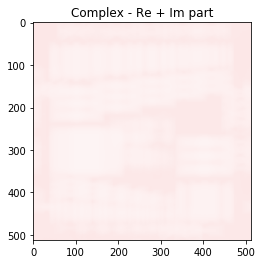

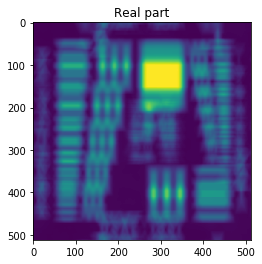

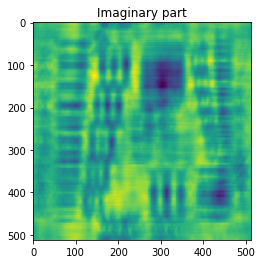

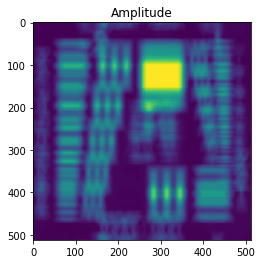

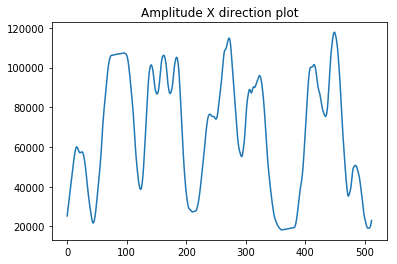

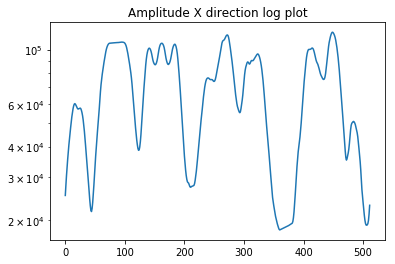

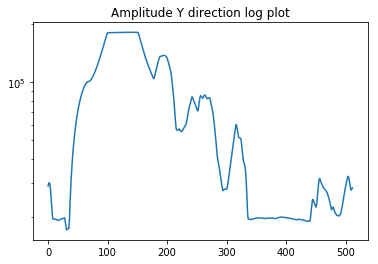

In [165]:
# 11 - convolution of FUSAF with FRECTA
convolved_FUSAF_FRECTA = np.multiply(FUSAF, FRECTA)
amp_pair_FUSAF_FRECTA = vis_diffractogram(convolved_FUSAF_FRECTA)
amp_pair_FUSAF_FRECTA_inverse = vis_diffractogram(generic_fft(convolved_FUSAF_FRECTA, inverse=True))

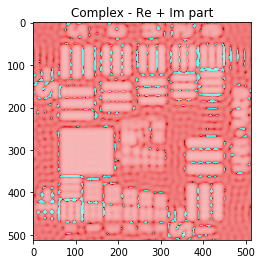

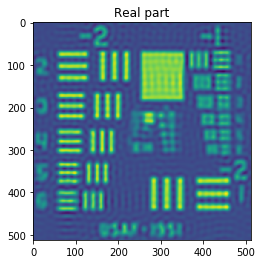

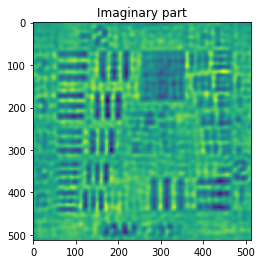

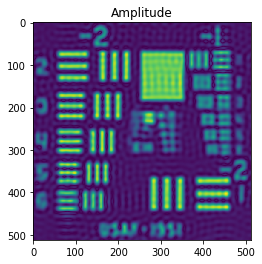

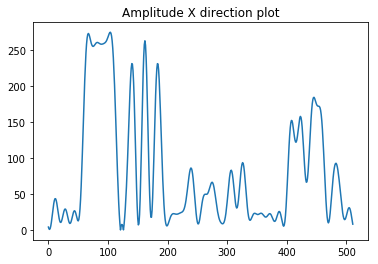

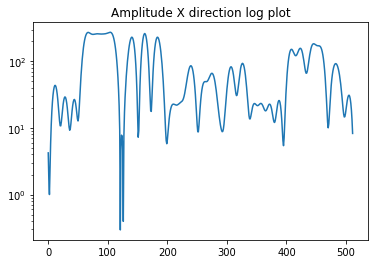

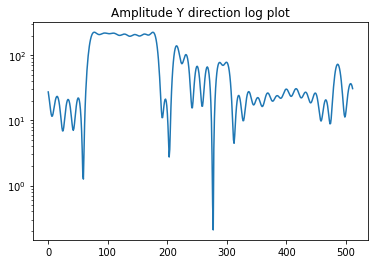

In [171]:
# 12 - not actually a convolution, simply multiplication of
# a frequency space image (FUSAF) with a real space image (RECTA)
MUL_FUSAF_CIRCA = np.multiply(FUSAF, CIRCA)
amp_pair = vis_diffractogram(generic_fft(MUL_FUSAF_CIRCA, inverse=True))

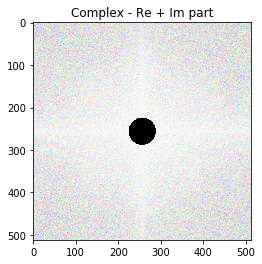

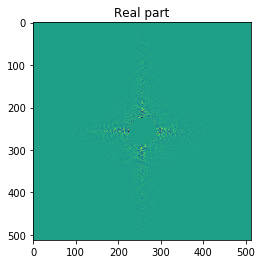

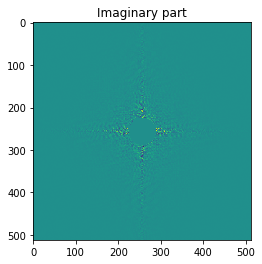

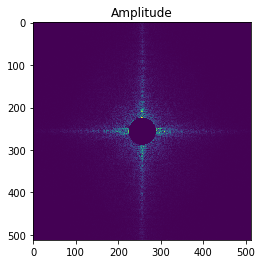

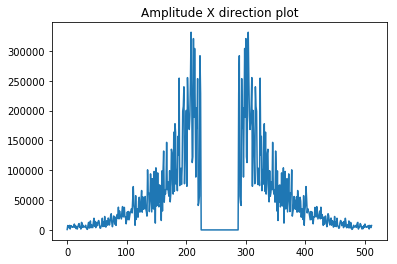

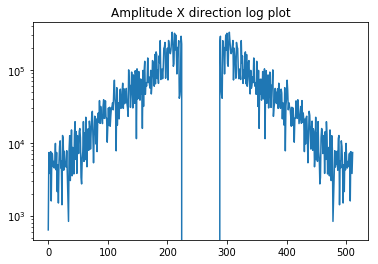

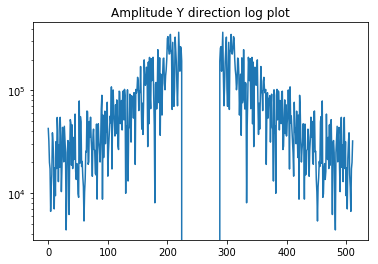

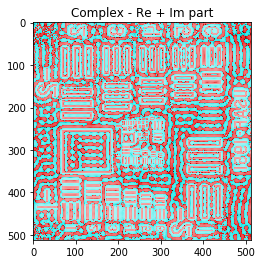

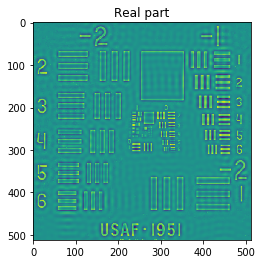

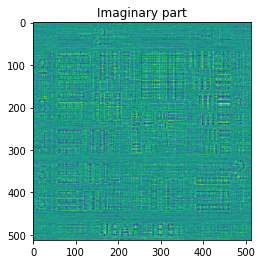

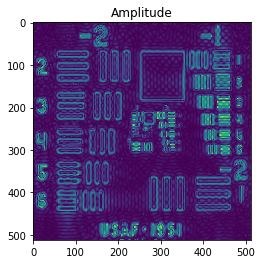

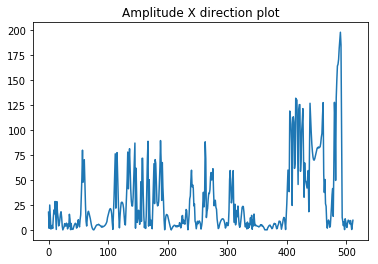

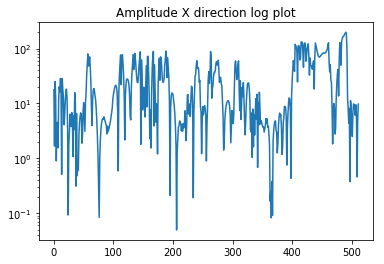

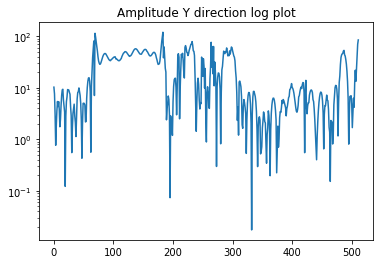

In [172]:
CIRCAINV = np.ones((512, 512))
rr, cc = draw.circle(256, 256, radius=32, shape=CIRCAINV.shape)
CIRCAINV[rr, cc] = 0

MUL_FUSAF_CIRCAINV = np.multiply(FUSAF, CIRCAINV)
amp_pair = vis_diffractogram(MUL_FUSAF_CIRCAINV)
amp_pair = vis_diffractogram(generic_fft(MUL_FUSAF_CIRCAINV, inverse=True))


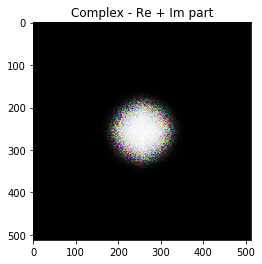

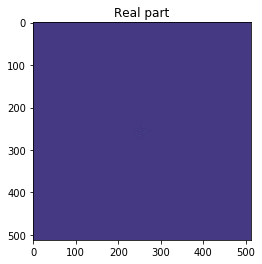

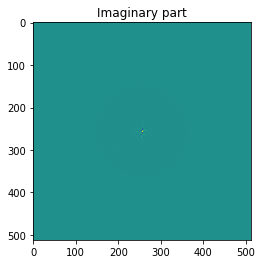

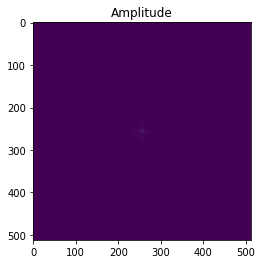

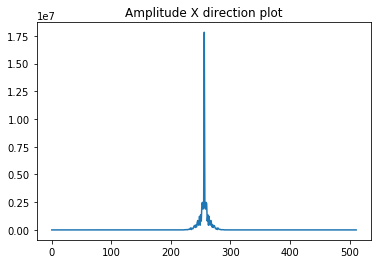

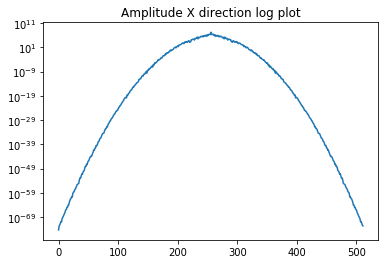

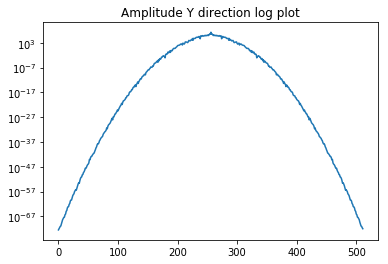

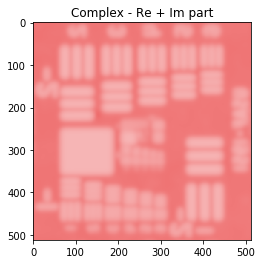

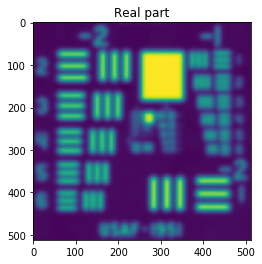

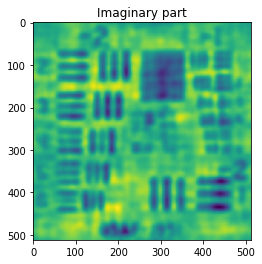

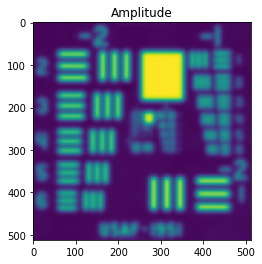

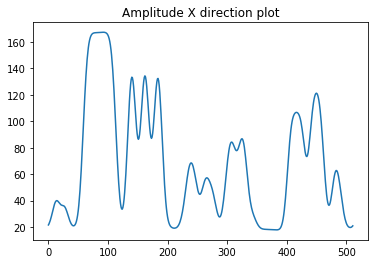

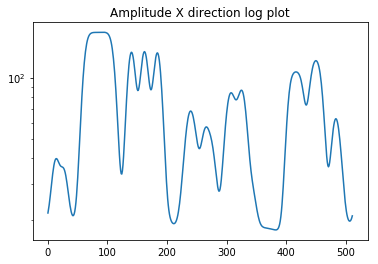

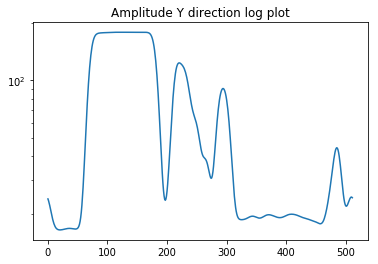

In [188]:
def two_dim_gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = xdata_tuple
    # Make sure the grid values are floats.
    xo = float(xo)
    yo = float(yo)
    # NB: if adapting for python 2.x (x>=2), always remember to:
    # from __future__ import division
    # otherwise, the below divisions will be of the floor variety -
    # output will always be integers.
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

x = np.arange(0, 512, 1, float)
y = x[:,np.newaxis]

x0 = 256
y0 = 256
fwhm = 32
GAUSSA = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
MUL_FUSAF_GAUSSA = np.multiply(FUSAF, GAUSSA)
amp = vis_diffractogram(MUL_FUSAF_GAUSSA)
amp = vis_diffractogram(generic_fft(MUL_FUSAF_GAUSSA, inverse=True))